In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
#pip install -U ydata-profiling

In [3]:
import pandas as pd
#from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/SEC_Data/2022q4_secdata.csv")
data.head()

,Unnamed: 0,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsGrantsInPeriodGross,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic
0,0,0000002178-22-000089,3.853470e+08,3.365790e+08,NaN,NaN,NaN,3.513100e+07,NaN,1353000.0,...,NaN,NaN,NaN,NaN,2787000.0,NaN,1.275652e+09,NaN,1.740300e+07,1.729200e+07
1,1,0000002488-22-000170,3.658000e+09,7.042000e+09,6.022000e+09,2.530000e+09,-9.100000e+07,NaN,6.865000e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.917500e+10,NaN,5.641000e+09,5.585000e+09
2,2,0000002969-22-000054,NaN,3.245700e+09,NaN,2.823380e+10,-4.302000e+09,NaN,2.257200e+09,133700000.0,...,NaN,1365000.0,205.93,237000.0,NaN,NaN,2.668370e+10,5.162180e+10,6.673000e+08,6.648000e+08
3,3,0000003499-22-000027,NaN,NaN,NaN,NaN,3.503200e+07,6.728000e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.354195e+09,NaN,2.050065e+07,2.050065e+07
4,4,0000003570-22-000106,5.600000e+08,NaN,5.407000e+09,NaN,NaN,8.686000e+09,NaN,198000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-8.750000e+09,1.591000e+09,1.009300e+09,1.009300e+09


In [5]:
data.shape

(7417, 143)

In [6]:
df_fraud_labels = pd.read_csv("gdrive/My Drive/Colab Notebooks/SEC_Data/Fraud_Labels.csv")
df_fraud_labels

,adsh
0,0001193125-22-304797
1,0001193125-22-290052
2,0001193125-22-288789
3,0001193125-22-289156
4,0001193125-22-275920
5,0000773840-22-000069
6,0000773840-22-000071
7,0001193125-22-269566
8,0001493152-22-028532
9,0000950170-22-026465


In [7]:
data["Fraud"] = data["adsh"].apply(lambda x: 1 if x in (df_fraud_labels.adsh.values) else 0)
data.head()

,Unnamed: 0,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
0,0,0000002178-22-000089,3.853470e+08,3.365790e+08,NaN,NaN,NaN,3.513100e+07,NaN,1353000.0,...,NaN,NaN,NaN,2787000.0,NaN,1.275652e+09,NaN,1.740300e+07,1.729200e+07,0
1,1,0000002488-22-000170,3.658000e+09,7.042000e+09,6.022000e+09,2.530000e+09,-9.100000e+07,NaN,6.865000e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,6.917500e+10,NaN,5.641000e+09,5.585000e+09,0
2,2,0000002969-22-000054,NaN,3.245700e+09,NaN,2.823380e+10,-4.302000e+09,NaN,2.257200e+09,133700000.0,...,1365000.0,205.93,237000.0,NaN,NaN,2.668370e+10,5.162180e+10,6.673000e+08,6.648000e+08,0
3,3,0000003499-22-000027,NaN,NaN,NaN,NaN,3.503200e+07,6.728000e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.354195e+09,NaN,2.050065e+07,2.050065e+07,0
4,4,0000003570-22-000106,5.600000e+08,NaN,5.407000e+09,NaN,NaN,8.686000e+09,NaN,198000000.0,...,NaN,NaN,NaN,NaN,NaN,-8.750000e+09,1.591000e+09,1.009300e+09,1.009300e+09,0


In [8]:
data[data.Fraud == 1]

,Unnamed: 0,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
447,447,0000773840-22-000071,1.260200e+10,1.419300e+10,1.492100e+10,NaN,-6.191000e+09,NaN,1.660100e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,3.627600e+10,5.568600e+10,2.765800e+09,2.737600e+09,1
1056,1056,0000950170-22-022129,3.590000e+08,4.156000e+08,1.778000e+08,8.872000e+08,-1.567000e+08,NaN,5.100000e+08,NaN,...,2176302.0,53.94,NaN,3700000.0,NaN,7.755000e+08,2.325000e+09,8.632600e+07,8.449600e+07,1
4503,4503,0001493152-22-028532,NaN,1.616600e+04,NaN,4.368890e+05,-1.286980e+05,16775229.0,NaN,NaN,...,NaN,NaN,NaN,57860.0,NaN,-2.165687e+07,NaN,1.040095e+10,3.873220e+09,1
6163,6163,0001628280-22-027596,1.612543e+09,3.892122e+09,2.691161e+09,5.067630e+09,-2.862956e+09,NaN,5.448970e+09,102434000.0,...,NaN,NaN,NaN,NaN,33180000.0,9.824535e+09,NaN,1.428451e+09,1.407931e+09,1
6630,6630,0001656472-22-000162,2.120700e+07,4.115900e+07,5.169800e+07,NaN,3.088500e+07,70787000.0,NaN,25493000.0,...,38067948.0,30.48,7943742.0,NaN,NaN,2.531380e+09,1.125850e+10,1.499266e+09,1.496069e+09,1


In [9]:
#profile = ProfileReport(data, minimal=True)

In [10]:
#profile.to_file("gdrive/My Drive/Colab Notebooks/SEC_Data/eda_report.html")

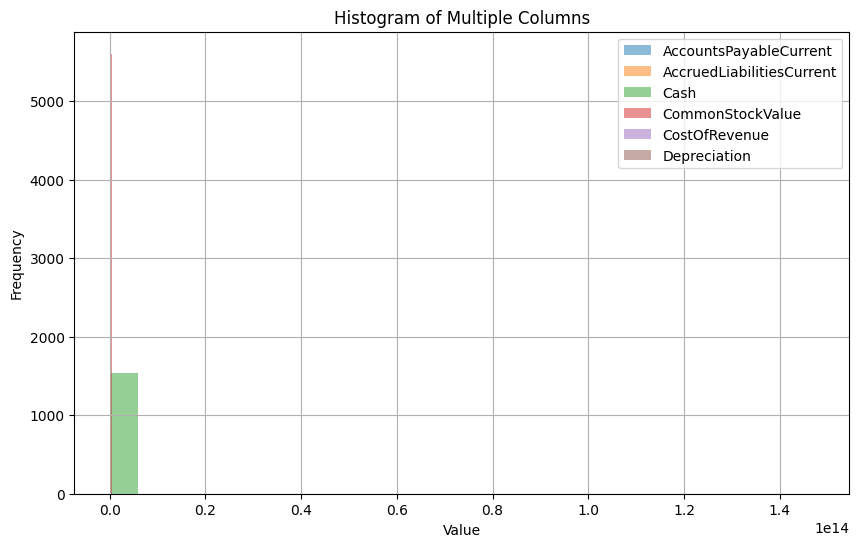

In [11]:
# Plot Histogram
colsforhist = ["AccountsPayableCurrent", "AccruedLiabilitiesCurrent", "Cash", "CommonStockValue", "CostOfRevenue", "Depreciation"]
plt.figure(figsize=(10, 6))  # Set the figure size
for column in colsforhist:
    plt.hist(data[column], bins=25, alpha=0.5, label=column)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.grid(True)

plt.show()

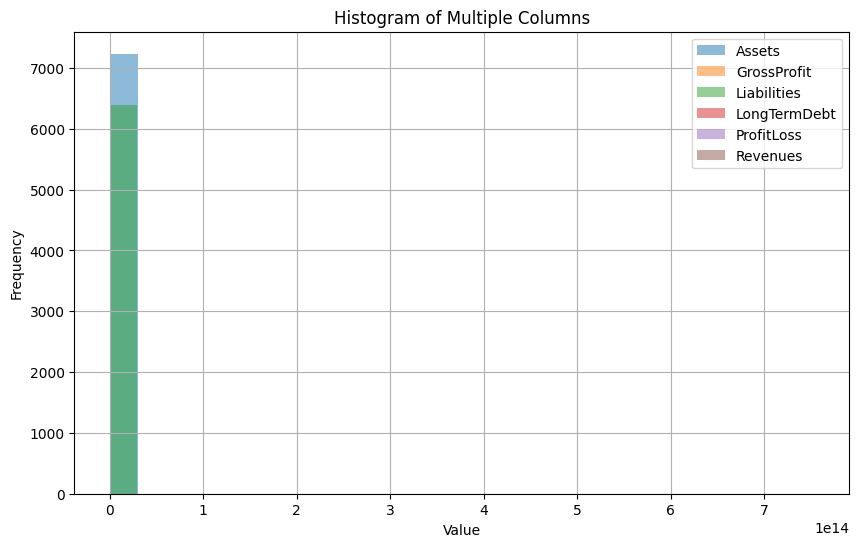

In [12]:
colsforhist = ["Assets", "GrossProfit", "Liabilities", "LongTermDebt", "ProfitLoss", "Revenues"]
plt.figure(figsize=(10, 6))  # Set the figure size
for column in colsforhist:
    plt.hist(data[column], bins=25, alpha=0.5, label=column)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.grid(True)

plt.show()

In [13]:
# Missing value imputation
data_new = data.fillna(data.median())
data_new.head()

,Unnamed: 0,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
0,0,0000002178-22-000089,3.853470e+08,3.365790e+08,1.415987e+07,3.081800e+07,-6.863500e+06,3.513100e+07,8.700000e+08,1353000.0,...,5085500.0,15.65,86000.0,2787000.0,869288.5,1.275652e+09,2.660001e+09,1.740300e+07,1.729200e+07,0
1,1,0000002488-22-000170,3.658000e+09,7.042000e+09,6.022000e+09,2.530000e+09,-9.100000e+07,1.933634e+08,6.865000e+10,17378500.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,6.917500e+10,2.660001e+09,5.641000e+09,5.585000e+09,0
2,2,0000002969-22-000054,1.502850e+07,3.245700e+09,1.415987e+07,2.823380e+10,-4.302000e+09,1.933634e+08,2.257200e+09,133700000.0,...,1365000.0,205.93,237000.0,9378000.0,869288.5,2.668370e+10,5.162180e+10,6.673000e+08,6.648000e+08,0
3,3,0000003499-22-000027,1.502850e+07,5.650000e+07,1.415987e+07,3.081800e+07,3.503200e+07,6.728000e+07,8.700000e+08,17378500.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,1.354195e+09,2.660001e+09,2.050065e+07,2.050065e+07,0
4,4,0000003570-22-000106,5.600000e+08,5.650000e+07,5.407000e+09,3.081800e+07,-6.863500e+06,8.686000e+09,8.700000e+08,198000000.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,-8.750000e+09,1.591000e+09,1.009300e+09,1.009300e+09,0


In [14]:
data_new.drop(columns=["Unnamed: 0"], inplace=True)
data_new.head()

,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
0,0000002178-22-000089,3.853470e+08,3.365790e+08,1.415987e+07,3.081800e+07,-6.863500e+06,3.513100e+07,8.700000e+08,1353000.0,19644000.0,...,5085500.0,15.65,86000.0,2787000.0,869288.5,1.275652e+09,2.660001e+09,1.740300e+07,1.729200e+07,0
1,0000002488-22-000170,3.658000e+09,7.042000e+09,6.022000e+09,2.530000e+09,-9.100000e+07,1.933634e+08,6.865000e+10,17378500.0,641000000.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,6.917500e+10,2.660001e+09,5.641000e+09,5.585000e+09,0
2,0000002969-22-000054,1.502850e+07,3.245700e+09,1.415987e+07,2.823380e+10,-4.302000e+09,1.933634e+08,2.257200e+09,133700000.0,149800000.0,...,1365000.0,205.93,237000.0,9378000.0,869288.5,2.668370e+10,5.162180e+10,6.673000e+08,6.648000e+08,0
3,0000003499-22-000027,1.502850e+07,5.650000e+07,1.415987e+07,3.081800e+07,3.503200e+07,6.728000e+07,8.700000e+08,17378500.0,19644000.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,1.354195e+09,2.660001e+09,2.050065e+07,2.050065e+07,0
4,0000003570-22-000106,5.600000e+08,5.650000e+07,5.407000e+09,3.081800e+07,-6.863500e+06,8.686000e+09,8.700000e+08,198000000.0,19644000.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,-8.750000e+09,1.591000e+09,1.009300e+09,1.009300e+09,0


In [15]:
# Plot skewness
skewness = data_new.drop(["adsh"], axis=1).apply(skew)

In [16]:
# Sort columns by skewness in descending order
sorted_skewness = skewness.sort_values(ascending=False)

# Get the top 10 columns with maximum skewness
top_20_skewness = sorted_skewness.head(20)

print(top_20_skewness)

CommonStockSharesAuthorized                                                            86.104588
WeightedAverageNumberOfDilutedSharesOutstanding                                        86.104584
EffectiveIncomeTaxRateContinuingOperations                                             86.104549
Cash                                                                                   86.104340
WeightedAverageNumberOfSharesOutstandingBasic                                          86.103512
PreferredStockSharesAuthorized                                                         86.016643
PreferredStockParOrStatedValuePerShare                                                 85.867160
FiniteLivedIntangibleAssetsNet                                                         85.142859
ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsGrantsInPeriodGross    85.132938
IncreaseDecreaseInAccountsPayable                                                      85.103308
CommonStockValue              

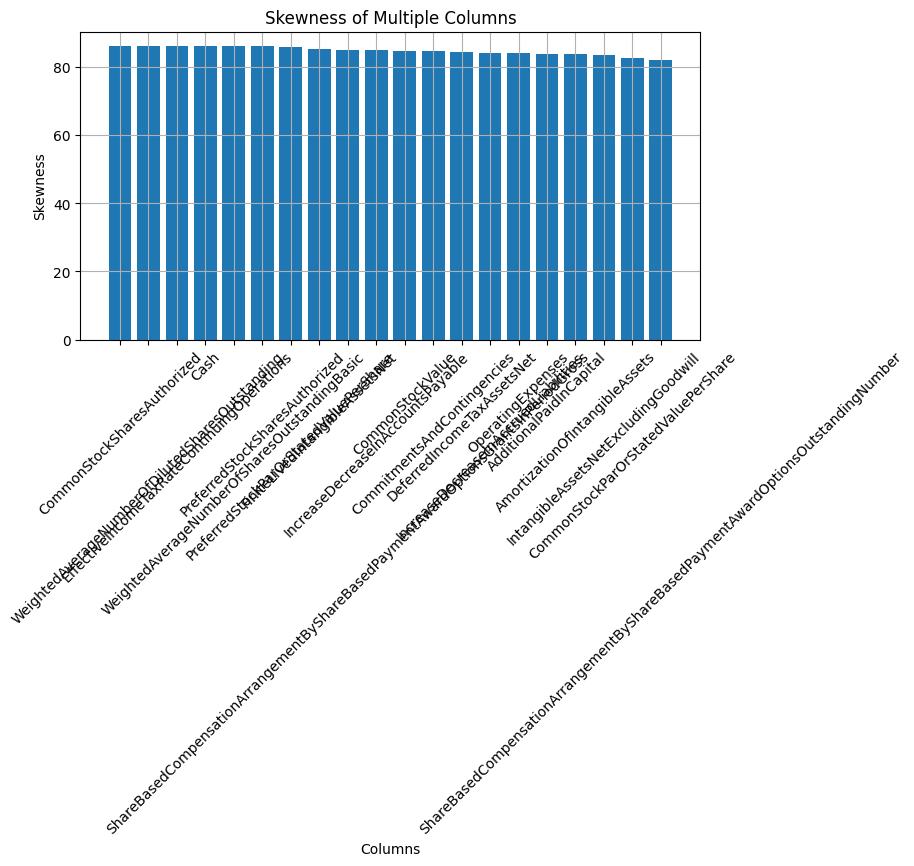

In [17]:
# Create a bar plot to visualize skewness
plt.figure(figsize=(8, 4))
plt.bar(top_20_skewness.index, top_20_skewness.values)
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.title('Skewness of Multiple Columns')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)

plt.show()

In [18]:
# Generate summary statistics
summary_stats = data_new.describe()

# Display the summary statistics
summary_stats.to_csv('gdrive/My Drive/Colab Notebooks/SEC_Data/summary_stats.csv')


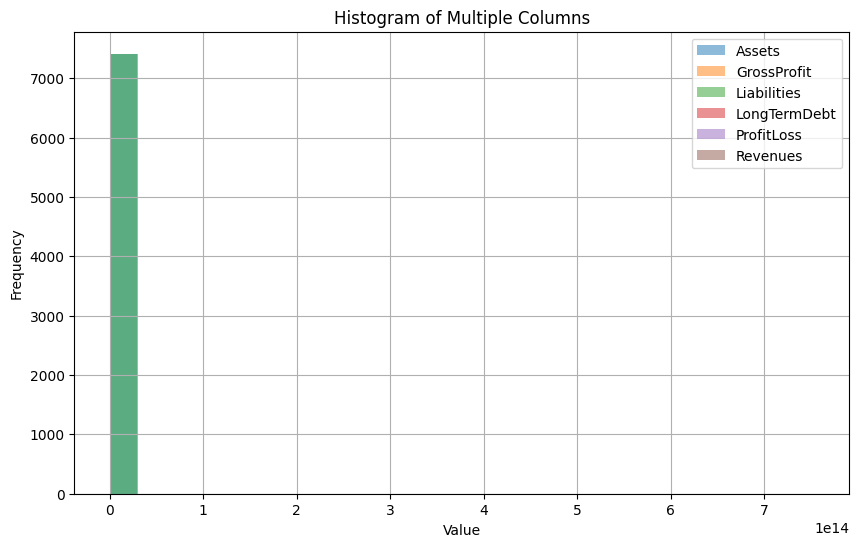

In [19]:
colsforhist = ["Assets", "GrossProfit", "Liabilities", "LongTermDebt", "ProfitLoss", "Revenues"]
plt.figure(figsize=(10, 6))  # Set the figure size
for column in colsforhist:
    plt.hist(data_new[column], bins=25, alpha=0.5, label=column)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.grid(True)

plt.show()

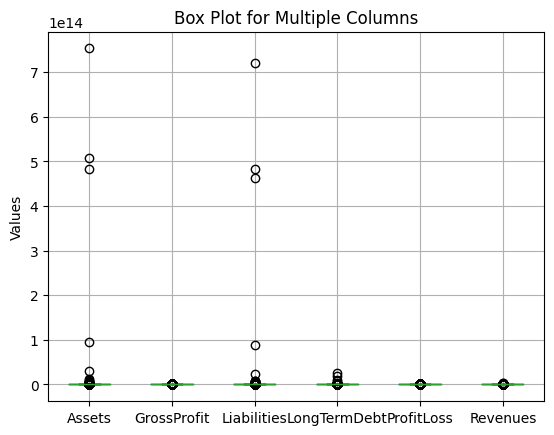

In [20]:
# Create a box plot for multiple columns
#plt.figure(figsize=(8, 6))
data_new.boxplot(column=colsforhist)
plt.title('Box Plot for Multiple Columns')
plt.ylabel('Values')
plt.show()

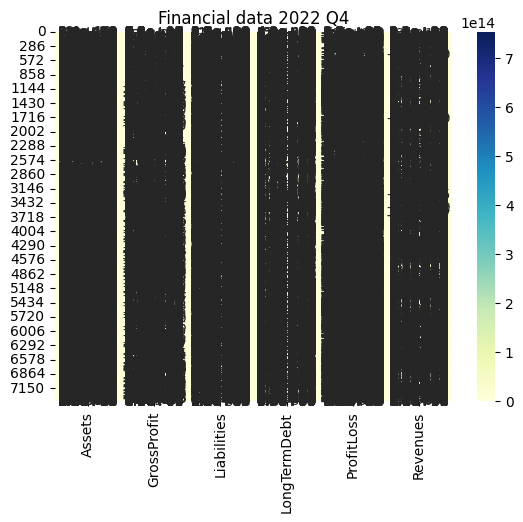

In [21]:
sns.heatmap(data_new[colsforhist], annot=True, cmap="YlGnBu")
plt.title("Financial data 2022 Q4")
plt.show()

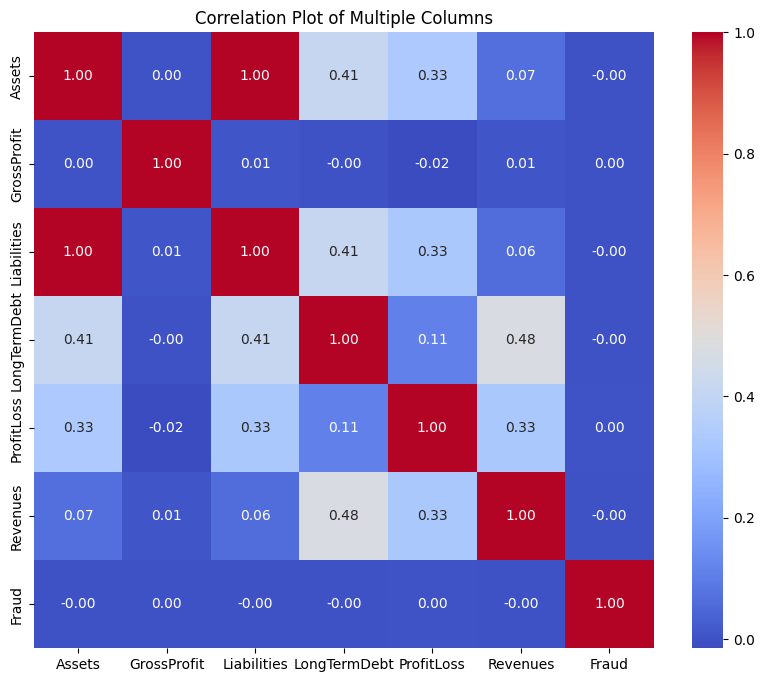

In [22]:
# Calculate the correlation matrix
colsforhist = ["Assets", "GrossProfit", "Liabilities", "LongTermDebt", "ProfitLoss", "Revenues", "Fraud"]
correlation_matrix = data_new[colsforhist].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot of Multiple Columns')
plt.show()

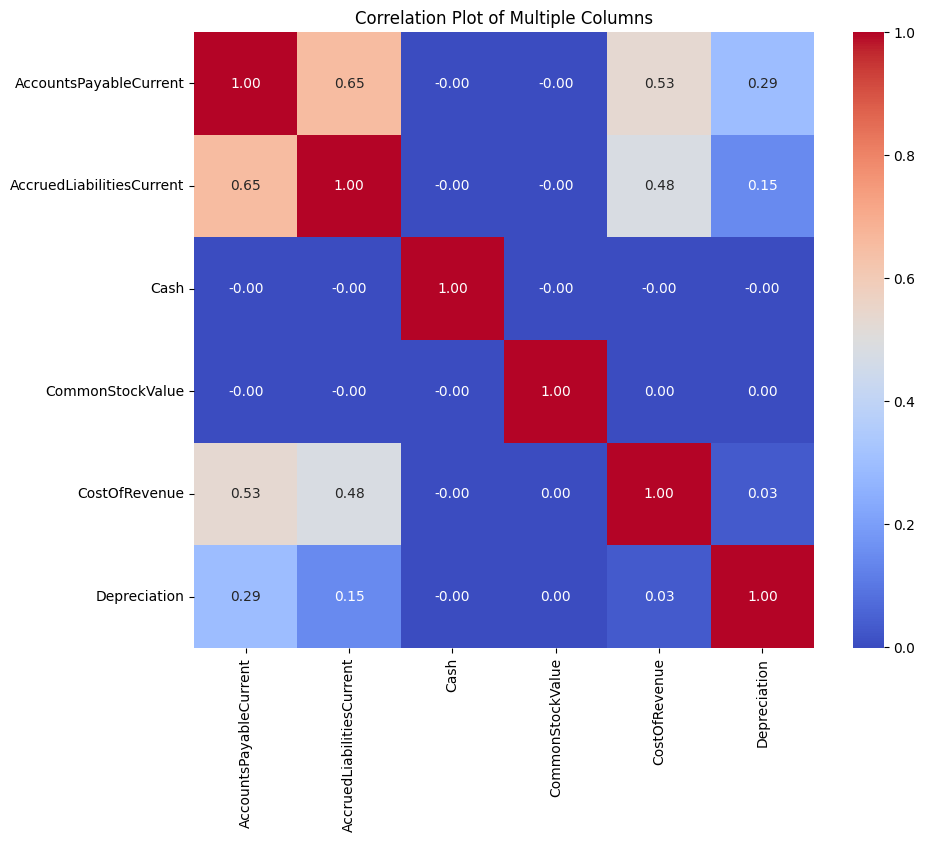

In [23]:
# Calculate the correlation matrix
colsforhist = ["AccountsPayableCurrent", "AccruedLiabilitiesCurrent", "Cash", "CommonStockValue", "CostOfRevenue", "Depreciation"]
correlation_matrix = data_new[colsforhist].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot of Multiple Columns')
plt.show()

In [24]:
data_final = data_new.drop(columns=["adsh"], axis=1)
data_final.head()


,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
0,3.853470e+08,3.365790e+08,1.415987e+07,3.081800e+07,-6.863500e+06,3.513100e+07,8.700000e+08,1353000.0,19644000.0,196000.0,...,5085500.0,15.65,86000.0,2787000.0,869288.5,1.275652e+09,2.660001e+09,1.740300e+07,1.729200e+07,0
1,3.658000e+09,7.042000e+09,6.022000e+09,2.530000e+09,-9.100000e+07,1.933634e+08,6.865000e+10,17378500.0,641000000.0,3496500.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,6.917500e+10,2.660001e+09,5.641000e+09,5.585000e+09,0
2,1.502850e+07,3.245700e+09,1.415987e+07,2.823380e+10,-4.302000e+09,1.933634e+08,2.257200e+09,133700000.0,149800000.0,3496500.0,...,1365000.0,205.93,237000.0,9378000.0,869288.5,2.668370e+10,5.162180e+10,6.673000e+08,6.648000e+08,0
3,1.502850e+07,5.650000e+07,1.415987e+07,3.081800e+07,3.503200e+07,6.728000e+07,8.700000e+08,17378500.0,19644000.0,3496500.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,1.354195e+09,2.660001e+09,2.050065e+07,2.050065e+07,0
4,5.600000e+08,5.650000e+07,5.407000e+09,3.081800e+07,-6.863500e+06,8.686000e+09,8.700000e+08,198000000.0,19644000.0,3496500.0,...,5085500.0,15.65,86000.0,9378000.0,869288.5,-8.750000e+09,1.591000e+09,1.009300e+09,1.009300e+09,0


In [25]:
X = data_final.drop(columns=["Fraud"])
y = data_final["Fraud"]



In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=100, stratify = y)
print("X_train shape : "+str(X_train.shape))
print("X_test shape : "+ str(X_test.shape))
print("y_train shape : "+ str(y_train.shape))
print("y_test shape : "+ str(y_test.shape))

X_train shape : (5191, 141)
X_test shape : (2226, 141)
y_train shape : (5191,)
y_test shape : (2226,)


In [27]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
X_train = power.fit_transform(X_train)
X_test = power.transform(X_test)

In [28]:
X_train = pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,0.490161,0.118741,1.382625,-0.022765,0.092868,-0.146333,0.196523,-0.013053,-0.064093,-0.02335,...,0.048579,0.010140,0.034904,0.021077,0.018645,-0.131834,0.003350,-0.015746,0.901562,0.873645
1,2.146146,2.676713,-0.007677,2.464986,0.051794,5.529441,-0.100541,5.139825,6.627028,-0.02335,...,0.048579,0.010140,0.034904,0.021077,-0.070893,-0.095075,-0.000953,0.279423,1.353017,1.242215
2,-0.037893,-0.010467,-0.007677,2.241508,-0.891646,-0.146333,0.475012,-0.047177,-0.064093,-0.02335,...,0.048579,0.010140,0.034904,0.021077,-0.070893,-0.095075,0.259721,-0.015746,1.842719,1.689974
3,-0.037893,-0.347696,-0.007677,-0.022765,0.092690,-0.106590,-0.100541,-0.047177,-0.064093,-0.02335,...,0.399603,-0.347269,-1.302372,-0.202216,-0.070893,-0.095075,-0.001484,-0.023868,0.632351,0.633454
4,-0.037893,-0.010467,-0.007677,-0.011686,0.109208,4.086890,-0.100541,-0.047177,-0.064093,-0.02335,...,0.048579,0.010140,0.034904,0.021077,9.780356,-0.095075,0.175846,0.325886,2.628903,2.346890


In [29]:
X_test = pd.DataFrame(X_test)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.663651,-0.010467,-0.466420,-0.022765,0.092864,-0.103001,-0.100541,-0.079740,-0.091465,-0.02335,...,0.124132,-0.168114,0.124441,0.021077,-0.070893,-0.112774,0.000963,-0.015746,-0.514749,-0.361225
1,-0.037893,-2.188485,-3.324619,-0.022765,0.091442,-0.162691,-0.100541,-0.047177,-0.064093,-0.02335,...,0.048579,0.010140,-0.333872,0.021077,-0.079935,-0.095075,-0.005261,-0.015746,-0.026538,-0.008772
2,-0.037893,-0.010467,-0.007677,-0.022765,0.092784,-0.146333,-0.199261,-0.044494,-0.064093,-0.02335,...,0.048579,-1.271265,1.501123,-0.192252,-0.070893,-0.132441,0.008320,-0.015746,-0.981810,-0.898707
3,-0.037893,-0.010467,-0.007677,-0.022765,0.091442,-0.146333,-0.100541,-0.047177,-0.064093,-0.02335,...,0.048579,0.010140,0.034904,0.021077,-0.083230,-0.095075,-0.024969,-0.015746,-0.026538,-0.008772
4,0.641743,-0.010467,1.545726,-0.022765,0.093283,1.054936,-0.100541,-0.047177,-0.064093,-0.02335,...,0.048579,0.010140,0.034904,0.021077,-0.083280,-0.095075,0.015110,0.018188,1.957136,1.790655


In [30]:
X_train.iloc[:5, :5]

,0,1,2,3,4
0,0.490161,0.118741,1.382625,-0.022765,0.092868
1,2.146146,2.676713,-0.007677,2.464986,0.051794
2,-0.037893,-0.010467,-0.007677,2.241508,-0.891646
3,-0.037893,-0.347696,-0.007677,-0.022765,0.092690
4,-0.037893,-0.010467,-0.007677,-0.011686,0.109208


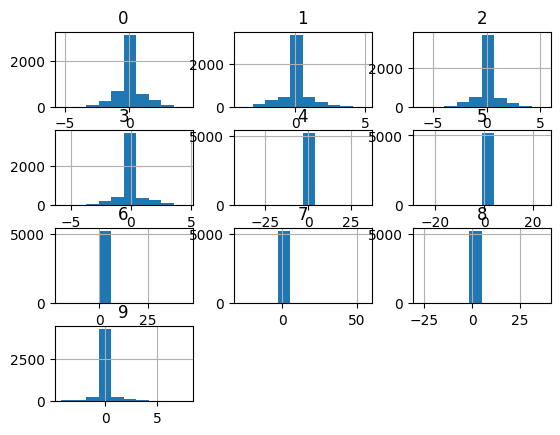

In [31]:
X_train.iloc[:, :10].hist()
plt.show()

In [32]:
y_train.value_counts()

0    5188
1       3
Name: Fraud, dtype: int64

In [33]:
colsize = 141

class cGAN():

    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """

    def __init__(self,latent_dim=colsize, out_shape=colsize):

        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = Adam(0.0002, 0.5)

        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True):

        # though not recommended, defining losses as global helps as in analysing our cgan out of the class
        global G_losses
        global D_losses

        G_losses = []
        D_losses = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # if sampling==True --> train discriminator with 8 sample from postivite class and rest with negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            # if sampling!=True --> train discriminator using random instances in batches of 32
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train.iloc[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

In [34]:
# Training CGAN
cgan = cGAN()

In [35]:
y_train = y_train.values.reshape(-1,1)

In [36]:
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
pos_index

array([ 433, 1136, 4297])

1/1 [==============================] - 0s 22ms/step
[99/700]	Loss_D: 0.6260	Loss_G: 0.8068
1/1 [==============================] - 0s 22ms/step
[199/700]	Loss_D: 0.4315	Loss_G: 1.0403
1/1 [==============================] - 0s 29ms/step
[299/700]	Loss_D: 0.4787	Loss_G: 1.2093
1/1 [==============================] - 0s 27ms/step
[399/700]	Loss_D: -1.3002	Loss_G: 1.6317
1/1 [==============================] - 0s 25ms/step
[499/700]	Loss_D: 0.5771	Loss_G: 1.5225
1/1 [==============================] - 0s 24ms/step
[599/700]	Loss_D: 0.4285	Loss_G: 1.6133
1/1 [==============================] - 0s 27ms/step
[699/700]	Loss_D: 0.4392	Loss_G: 1.7057


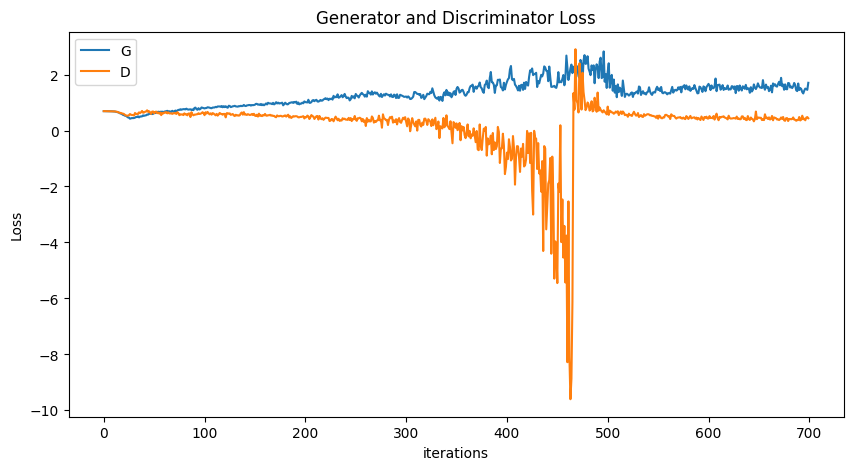

In [37]:
cgan.train(X_train, y_train, pos_index, neg_index, epochs=700, sampling=True)

In [38]:
# we want to generate 4150 instances with class value 1 since that represents about 80% of how many 0s are in the label of the real training set
noise_2 = np.random.normal(0, 1, (4150, colsize))
sampled_labels_2 = np.ones(4150).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = X_train.columns)

130/130 [==============================] - 1s 3ms/step


In [39]:
gen_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.921712,0.999947,0.999483,0.325930,0.904734,0.999627,0.977208,-0.928747,-0.999720,-0.999686,...,0.998697,0.913945,-0.691291,1.000000,0.963869,-0.980408,0.963142,-0.854680,0.999997,1.000000
1,-0.997873,-0.012500,-0.995254,-0.970616,0.079494,0.988606,0.985747,0.586864,-0.309731,-0.997843,...,0.953239,0.330968,0.393140,0.925275,0.917408,-0.878686,0.920675,0.372950,0.782369,0.974188
2,-0.834397,-0.852303,-0.959739,-0.241077,-0.295596,-0.923207,0.347536,-0.665204,0.121213,0.261751,...,0.617030,-0.351984,0.708750,-0.961974,-0.721040,0.906560,-0.900611,0.801445,-0.972856,-0.719612
3,-0.567849,0.619518,-0.740084,0.452838,0.049513,-0.951861,-0.510401,-0.412963,-0.421158,0.806235,...,-0.700301,-0.817490,0.156351,-0.998917,-0.050018,0.765832,0.590743,0.490436,-0.970164,-0.211170
4,-0.799573,0.882074,-0.656542,-0.062424,0.524383,0.230536,0.385058,-0.262325,-0.784311,0.051796,...,0.938568,-0.230956,0.136889,0.964155,-0.445207,0.532593,0.284986,0.731784,-0.465593,0.909861


In [40]:
gen_df_2["Fraud"] = 1
gen_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,132,133,134,135,136,137,138,139,140,Fraud
0,-0.921712,0.999947,0.999483,0.325930,0.904734,0.999627,0.977208,-0.928747,-0.999720,-0.999686,...,0.913945,-0.691291,1.000000,0.963869,-0.980408,0.963142,-0.854680,0.999997,1.000000,1
1,-0.997873,-0.012500,-0.995254,-0.970616,0.079494,0.988606,0.985747,0.586864,-0.309731,-0.997843,...,0.330968,0.393140,0.925275,0.917408,-0.878686,0.920675,0.372950,0.782369,0.974188,1
2,-0.834397,-0.852303,-0.959739,-0.241077,-0.295596,-0.923207,0.347536,-0.665204,0.121213,0.261751,...,-0.351984,0.708750,-0.961974,-0.721040,0.906560,-0.900611,0.801445,-0.972856,-0.719612,1
3,-0.567849,0.619518,-0.740084,0.452838,0.049513,-0.951861,-0.510401,-0.412963,-0.421158,0.806235,...,-0.817490,0.156351,-0.998917,-0.050018,0.765832,0.590743,0.490436,-0.970164,-0.211170,1
4,-0.799573,0.882074,-0.656542,-0.062424,0.524383,0.230536,0.385058,-0.262325,-0.784311,0.051796,...,-0.230956,0.136889,0.964155,-0.445207,0.532593,0.284986,0.731784,-0.465593,0.909861,1


In [41]:
real_data = pd.concat([X_train, pd.DataFrame(y_train, columns=["Fraud"])], axis=1)
real_data.head()


,0,1,2,3,4,5,6,7,8,9,...,132,133,134,135,136,137,138,139,140,Fraud
0,0.490161,0.118741,1.382625,-0.022765,0.092868,-0.146333,0.196523,-0.013053,-0.064093,-0.02335,...,0.010140,0.034904,0.021077,0.018645,-0.131834,0.003350,-0.015746,0.901562,0.873645,0
1,2.146146,2.676713,-0.007677,2.464986,0.051794,5.529441,-0.100541,5.139825,6.627028,-0.02335,...,0.010140,0.034904,0.021077,-0.070893,-0.095075,-0.000953,0.279423,1.353017,1.242215,0
2,-0.037893,-0.010467,-0.007677,2.241508,-0.891646,-0.146333,0.475012,-0.047177,-0.064093,-0.02335,...,0.010140,0.034904,0.021077,-0.070893,-0.095075,0.259721,-0.015746,1.842719,1.689974,0
3,-0.037893,-0.347696,-0.007677,-0.022765,0.092690,-0.106590,-0.100541,-0.047177,-0.064093,-0.02335,...,-0.347269,-1.302372,-0.202216,-0.070893,-0.095075,-0.001484,-0.023868,0.632351,0.633454,0
4,-0.037893,-0.010467,-0.007677,-0.011686,0.109208,4.086890,-0.100541,-0.047177,-0.064093,-0.02335,...,0.010140,0.034904,0.021077,9.780356,-0.095075,0.175846,0.325886,2.628903,2.346890,0


In [42]:
df_gan = pd.concat([real_data, gen_df_2], axis=0, ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)
df_gan.head()


,0,1,2,3,4,5,6,7,8,9,...,132,133,134,135,136,137,138,139,140,Fraud
0,-0.037893,-0.010467,-0.007677,-0.022765,0.091442,-0.146333,-0.100541,-0.047177,-0.064093,-0.023350,...,0.010140,0.034904,0.021077,-0.070893,-0.095075,-0.000953,-0.015746,-0.026538,-0.008772,0
1,-0.037893,0.876382,-0.007677,1.167137,0.092940,-0.146333,-0.105996,0.007111,-0.064093,0.809543,...,0.010140,0.034904,0.021077,-0.070893,-0.095075,0.002638,-0.016827,0.389950,0.328419,0
2,-0.037893,-0.010467,-0.007677,-0.022765,-0.356057,-0.146333,0.049918,-0.047177,-0.064093,-0.023350,...,0.010140,0.034904,0.021077,-0.070893,-0.095075,0.071631,0.022771,1.253739,1.177416,0
3,-0.861703,-0.983177,-0.990037,-0.387596,-0.454282,-0.988015,-0.792882,-0.046626,0.716956,0.877261,...,-0.640055,-0.072763,-0.999999,-0.399284,0.905721,-0.296380,0.945486,-0.998013,-0.997173,1
4,-1.325602,-0.010467,-1.708418,-0.022765,0.091442,-0.146333,-0.100541,-0.047177,-0.064093,-0.023350,...,0.010140,0.034904,0.021077,-0.070893,-0.095075,-0.000953,-0.015746,-0.026538,-0.008772,0


In [43]:
X_train_2 = df_gan.drop('Fraud', axis=1)
y_train_2 = df_gan['Fraud'].values

[LightGBM] [Info] Number of positive: 4153, number of negative: 5188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35953
[LightGBM] [Info] Number of data points in the train set: 9341, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444599 -> initscore=-0.222517
[LightGBM] [Info] Start training from score -0.222517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

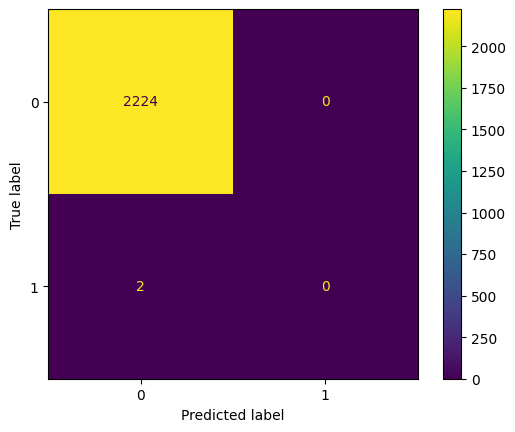

In [44]:
# Experiment 1 - LGBM
# Classify using generated train set
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred_gan_lgbm = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred_gan_lgbm))
ConfusionMatrixDisplay.from_estimator(lgb_1, X_test, y_test)
plt.show()

In [45]:
# Calculate metrics
precision = precision_score(y_test, y_pred_gan_lgbm)
recall = recall_score(y_test, y_pred_gan_lgbm)
f1 = f1_score(y_test, y_pred_gan_lgbm)
accuracy = accuracy_score(y_test, y_pred_gan_lgbm)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy]})

# Print the results in a tabular format
print(results)

      Metric     Score
0  Precision  0.000000
1     Recall  0.000000
2   F1 Score  0.000000
3   Accuracy  0.999102


[LightGBM] [Info] Number of positive: 3, number of negative: 5188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34377
[LightGBM] [Info] Number of data points in the train set: 5191, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000578 -> initscore=-7.455491
[LightGBM] [Info] Start training from score -7.455491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

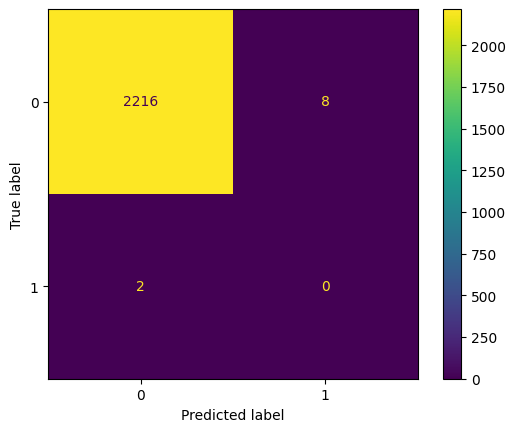

In [46]:
# Classify using original train set
lgb_2 = lgb.LGBMClassifier()
lgb_2.fit(X_train, y_train)


y_pred_lgbm = lgb_2.predict(X_test)

print(classification_report(y_test, y_pred_lgbm))
ConfusionMatrixDisplay.from_estimator(lgb_2, X_test, y_test)
plt.show()

In [47]:
# Calculate metrics
precision = precision_score(y_test, y_pred_lgbm)
recall = recall_score(y_test, y_pred_lgbm)
f1 = f1_score(y_test, y_pred_lgbm)
accuracy = accuracy_score(y_test, y_pred_lgbm)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy]})

# Print the results in a tabular format
print(results)

      Metric     Score
0  Precision  0.000000
1     Recall  0.000000
2   F1 Score  0.000000
3   Accuracy  0.995508


Experiment 2 - XGBOD

In [49]:
pip install -U pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.1-py3-none-any.whl size=190074 sha256=b8918629dbdc5ff2207219ef3082b2eb5db72910049ee9651c3e78bd461ceb42
  Stored in directory: /root/.cache/pip/wheels/a3/42/d7/48a53ffc1466bd63932f28583c64ebf442114db14a0bfa8c95
Successfully built pyod


In [50]:
from pyod.models.xgbod import XGBOD

In [51]:
#Original data
# Initialize the XGBOD model
model = XGBOD()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict outliers on the test data
y_test_pred_xgbod = model.predict(X_test)

In [52]:
# Calculate metrics
precision = precision_score(y_test, y_test_pred_xgbod)
recall = recall_score(y_test, y_test_pred_xgbod)
f1 = f1_score(y_test, y_test_pred_xgbod)
accuracy = accuracy_score(y_test, y_test_pred_xgbod)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy]})

# Print the results in a tabular format
print(results)

      Metric     Score
0  Precision  0.000000
1     Recall  0.000000
2   F1 Score  0.000000
3   Accuracy  0.999102


In [53]:
# Augmented data
# Initialize the XGBOD model
model2 = XGBOD()

# Fit the model to the training data
model2.fit(X_train_2, y_train_2)

# Predict outliers on the test data
y_test_pred_gan_xgbod = model2.predict(X_test)

In [54]:
# Calculate metrics
precision = precision_score(y_test, y_test_pred_gan_xgbod)
recall = recall_score(y_test, y_test_pred_gan_xgbod)
f1 = f1_score(y_test, y_test_pred_gan_xgbod)
accuracy = accuracy_score(y_test, y_test_pred_gan_xgbod)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy]})

# Print the results in a tabular format
print(results)

      Metric     Score
0  Precision  0.000000
1     Recall  0.000000
2   F1 Score  0.000000
3   Accuracy  0.999102


Experiment 3 - SVM

In [55]:
from sklearn.svm import SVC

In [56]:
#Original data
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_svm = svm_classifier.predict(X_test)


In [57]:
# Calculate metrics
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
accuracy = accuracy_score(y_test, y_pred_svm)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy]})

# Print the results in a tabular format
print(results)

      Metric     Score
0  Precision  0.000000
1     Recall  0.000000
2   F1 Score  0.000000
3   Accuracy  0.996406


In [58]:
# Augmented data
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train_2, y_train_2)

# Make predictions on the test data
y_pred_gan_svm = svm_classifier.predict(X_test)

In [59]:
# Calculate metrics
precision = precision_score(y_test, y_pred_gan_svm)
recall = recall_score(y_test, y_pred_gan_svm)
f1 = f1_score(y_test, y_pred_gan_svm)
accuracy = accuracy_score(y_test, y_pred_gan_svm)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy]})

# Print the results in a tabular format
print(results)

      Metric     Score
0  Precision  0.000000
1     Recall  0.000000
2   F1 Score  0.000000
3   Accuracy  0.989668


Experiment 4 - Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
# Original data
# Create a logistic regression classifier
logistic_classifier = LogisticRegression()

# Train the logistic regression classifier on the training data
logistic_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgreg = logistic_classifier.predict(X_test)

In [62]:
# Calculate metrics
precision = precision_score(y_test, y_pred_lgreg)
recall = recall_score(y_test, y_pred_lgreg)
f1 = f1_score(y_test, y_pred_lgreg)
accuracy = accuracy_score(y_test, y_pred_lgreg)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy]})

# Print the results in a tabular format
print(results)

      Metric     Score
0  Precision  0.000000
1     Recall  0.000000
2   F1 Score  0.000000
3   Accuracy  0.996406


In [63]:
# Augmented data
# Create a logistic regression classifier
logistic_classifier2 = LogisticRegression()

# Train the logistic regression classifier on the training data
logistic_classifier2.fit(X_train_2, y_train_2)

# Make predictions on the test data
y_pred_gan_lgreg = logistic_classifier2.predict(X_test)

In [64]:
# Calculate metrics
precision = precision_score(y_test, y_pred_gan_lgreg)
recall = recall_score(y_test, y_pred_gan_lgreg)
f1 = f1_score(y_test, y_pred_gan_lgreg)
accuracy = accuracy_score(y_test, y_pred_gan_lgreg)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score': [precision, recall, f1, accuracy]})

# Print the results in a tabular format
print(results)

      Metric     Score
0  Precision  0.000000
1     Recall  0.000000
2   F1 Score  0.000000
3   Accuracy  0.985624
